Load the Libraries


In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Ignore Warning


In [117]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [118]:
df_rating = pd.read_csv('corporateCreditRatingWithFinancialRatios.csv')
df_rating.head()

#df_rating.shape

,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,Standard & Poor's Ratings Services,American States Water Co.,A-,30/07/10,1056903,1,4941,Utils,AWR,1.1507,...,28.9834,13.6093,8.3224,0.3173,8.1724,8.1978,2.6385,4.4530,1.9957,-0.1333
1,Standard & Poor's Ratings Services,Automatic Data Processing Inc.,AAA,16/09/10,8670,1,7374,BusEq,ADP,1.1129,...,23.9379,20.8699,13.5690,0.3324,22.0354,47.2858,4.4944,21.8765,0.2501,0.3132
2,Standard & Poor's Ratings Services,Avnet Inc.,BBB-,23/11/10,8858,1,5065,Shops,AVT,1.9276,...,3.6338,3.0536,2.1418,2.4620,13.6376,16.7991,5.2731,9.6494,-7.6079,-7.3231
3,Standard & Poor's Ratings Services,California Water Service Co.,AA-,29/06/10,1035201,1,4941,Utils,CWT,0.8358,...,27.9377,15.1135,9.0246,0.2946,9.6412,9.7015,2.6583,5.1018,1.7438,-0.8999
4,Standard & Poor's Ratings Services,Cardinal Health Inc.,A,14/07/10,721371,1,5122,Shops,CAH,1.2931,...,1.5847,1.2304,0.6518,4.9276,11.1256,19.4184,2.9364,8.1844,1.9725,2.4174


In [119]:
#Read the SIC Codes data scraped from the SEC.gov site

SICRange_data = pd.read_csv('SICRangedata.csv')
SICRange_data
#SICRange_data.shape

,Range of SIC Codes\n,Division\n
0,0100-0999\n,"Agriculture, Forestry and Fishing\n"
1,1000-1499\n,Mining\n
2,1500-1799\n,Construction\n
3,1800-1999\n,not used\n
4,2000-3999\n,Manufacturing\n
5,4000-4999\n,"Transportation, Communications, Electric, Gas ..."
6,5000-5199\n,Wholesale Trade\n
7,5200-5999\n,Retail Trade\n
8,6000-6799\n,"Finance, Insurance and Real Estate\n"
9,7000-8999\n,Services\n


In [120]:
SICRange_data.columns = SICRange_data.columns.str.replace('\n','')
SICRange_data.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=["",""], regex=True, inplace=True)

#SICRange_data['Range of SIC Codes'].astype(str).astype(int)
SICRange_data.rename(columns={'Range of SIC Codes':'CodeRange', 'Division':'Sector'}, inplace=True)
SICRange_data.head()

,CodeRange,Sector
0,0100-0999,"Agriculture, Forestry and Fishing"
1,1000-1499,Mining
2,1500-1799,Construction
3,1800-1999,not used
4,2000-3999,Manufacturing


In [121]:
#SICRange_data
SICRange_data[['Start', 'End']] = SICRange_data.CodeRange.apply(lambda x: pd.Series(str(x).split("-")))
print(SICRange_data)

SICRange_data['End'] = pd.to_numeric(SICRange_data['End'])
SICRange_data['Start'] = pd.to_numeric(SICRange_data['Start'])
SICRange_data.dtypes

    CodeRange                                             Sector Start   End
0   0100-0999                  Agriculture, Forestry and Fishing  0100  0999
1   1000-1499                                             Mining  1000  1499
2   1500-1799                                       Construction  1500  1799
3   1800-1999                                           not used  1800  1999
4   2000-3999                                      Manufacturing  2000  3999
5   4000-4999  Transportation, Communications, Electric, Gas ...  4000  4999
6   5000-5199                                    Wholesale Trade  5000  5199
7   5200-5999                                       Retail Trade  5200  5999
8   6000-6799                 Finance, Insurance and Real Estate  6000  6799
9   7000-8999                                           Services  7000  8999
10  9100-9729                              Public Administration  9100  9729
11  9900-9999                                    Nonclassifiable  9900  9999

CodeRange    object
Sector       object
Start         int64
End           int64
dtype: object

In [107]:
df1 = {'SICCode':[1230, 4974, 5120, 9997], 'Sector':['Agro','Utils', 'shops', 'Utils']}
df1 = pd.DataFrame(df1)
df1.head()

,SICCode,Sector
0,1230,Agro
1,4974,Utils
2,5120,shops
3,9997,Utils


In [122]:
data = []
for i in range(len(df_rating)):
    code = df_rating['SIC Code'].iloc[i]
    for j in range(len(SICRange_data)):
        start = SICRange_data['Start'].iloc[j]
        end = SICRange_data['End'].iloc[j]
        if code >= start and code <= end:
            data.append(SICRange_data['Sector'].iloc[j])
            continue
df_rating['Sector'] = data

df_rating

,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,Standard & Poor's Ratings Services,American States Water Co.,A-,30/07/10,1056903,1,4941,"Transportation, Communications, Electric, Gas ...",AWR,1.1507,...,28.9834,13.6093,8.3224,0.3173,8.1724,8.1978,2.6385,4.4530,1.9957,-0.1333
1,Standard & Poor's Ratings Services,Automatic Data Processing Inc.,AAA,16/09/10,8670,1,7374,Services,ADP,1.1129,...,23.9379,20.8699,13.5690,0.3324,22.0354,47.2858,4.4944,21.8765,0.2501,0.3132
2,Standard & Poor's Ratings Services,Avnet Inc.,BBB-,23/11/10,8858,1,5065,Wholesale Trade,AVT,1.9276,...,3.6338,3.0536,2.1418,2.4620,13.6376,16.7991,5.2731,9.6494,-7.6079,-7.3231
3,Standard & Poor's Ratings Services,California Water Service Co.,AA-,29/06/10,1035201,1,4941,"Transportation, Communications, Electric, Gas ...",CWT,0.8358,...,27.9377,15.1135,9.0246,0.2946,9.6412,9.7015,2.6583,5.1018,1.7438,-0.8999
4,Standard & Poor's Ratings Services,Cardinal Health Inc.,A,14/07/10,721371,1,5122,Wholesale Trade,CAH,1.2931,...,1.5847,1.2304,0.6518,4.9276,11.1256,19.4184,2.9364,8.1844,1.9725,2.4174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7800,Moody's Investors Service,"eBay, Inc.",BBB+,22/02/16,1065088,1,7370,Services,EBAY,3.4927,...,33.5661,28.0028,20.0768,0.4839,29.6077,95.6757,10.9659,14.6116,-1.2323,-1.2826
7801,Moody's Investors Service,"eBay, Inc.",BBB+,02/03/16,1065088,1,7370,Services,EBAY,3.4927,...,33.5661,28.0028,20.0768,0.4839,29.6077,95.6757,10.9659,14.6116,-1.2323,-1.2826
7802,Standard & Poor's Ratings Services,iHeartCommunications Inc.,CC,08/03/16,739708,0,4832,"Transportation, Communications, Electric, Gas ...",CCU,1.7606,...,14.2454,12.7232,8.0626,0.8218,11.8335,13.5108,7.7070,10.6101,0.0907,1.2552
7803,Standard & Poor's Ratings Services,iHeartCommunications Inc.,CCC,24/03/16,739708,0,4832,"Transportation, Communications, Electric, Gas ...",CCU,1.7606,...,14.2454,12.7232,8.0626,0.8218,11.8335,13.5108,7.7070,10.6101,0.0907,1.2552


In [123]:
df_rating.loc[df_rating['Sector'] == 'Other']


,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share


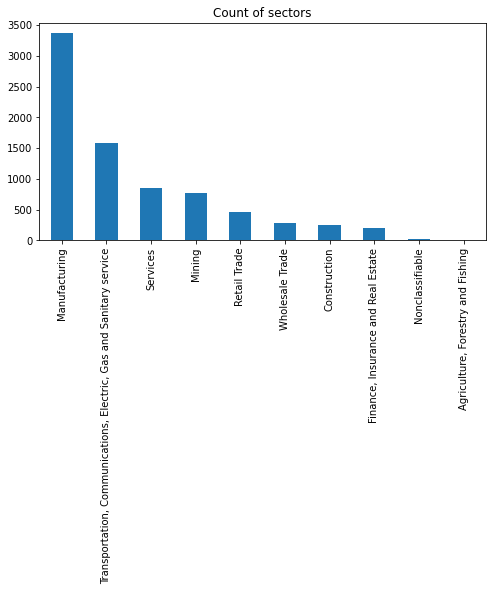

In [125]:
#attempt to plot all the sectors on a grid

ax = df_rating['Sector'].value_counts().plot(kind='bar', figsize=(8,4), title='Count of sectors', grid=False)


In [15]:
df_rating['Rating'].value_counts()


BBB     910
BBB+    846
A       836
A-      722
BBB-    705
BB+     545
A+      478
BB      453
BB-     427
B+      422
B       310
B-      288
AA-     254
AA      185
CCC+    151
AAA      90
AA+      73
CCC      65
CC       18
C        11
CCC-     10
D         5
CC+       1
Name: Rating, dtype: int64